In [1]:
!pip install -q datasets


In [2]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
dataset = load_dataset("oneonlee/cleansed_emocontext")  # EmoContext cleaned version
print(dataset)

train_df = pd.DataFrame(dataset['train'])
val_df   = pd.DataFrame(dataset['validation'])
test_df  = pd.DataFrame(dataset['test'])

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)
print(train_df.head())
print(train_df.columns)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

cleansed_train.csv: 0.00B [00:00, ?B/s]

cleansed_dev.csv: 0.00B [00:00, ?B/s]

cleansed_test.csv: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['turn1', 'turn2', 'turn3', 'label'],
        num_rows: 30160
    })
    validation: Dataset({
        features: ['turn1', 'turn2', 'turn3', 'label'],
        num_rows: 2755
    })
    test: Dataset({
        features: ['turn1', 'turn2', 'turn3', 'label'],
        num_rows: 5509
    })
})
Train: (30160, 4) Val: (2755, 4) Test: (5509, 4)
                  turn1                                              turn2  \
0  don't worry i'm girl                       hmm how do i know if you are   
1          when did i ?                         saw many times i think - -   
2                    by                                   by google chrome   
3      u are ridiculous  i might be ridiculous but i am telling the tru...   
4    just for time pass                       wt do you do 4 a living then   

                       turn3  label  
0         what's your name ?      0  
1       no . i never saw you      3  
2             where you l

In [4]:
def build_text(row):
    return f"{row['turn1']} [SEP] {row['turn2']} [SEP] {row['turn3']}"

for df in (train_df, val_df, test_df):
    df['text'] = df.apply(build_text, axis=1)

print(train_df[['text', 'label']].head())
print(train_df['label'].value_counts())


                                                text  label
0  don't worry i'm girl [SEP] hmm how do i know i...      0
1  when did i ? [SEP] saw many times i think - - ...      3
2     by [SEP] by google chrome [SEP] where you live      0
3  u are ridiculous [SEP] i might be ridiculous b...      3
4  just for time pass [SEP] wt do you do 4 a livi...      0
label
0    14948
3     5506
2     5463
1     4243
Name: count, dtype: int64


In [5]:
id2label = {0: 'others', 1: 'happy', 2: 'sad', 3: 'angry'}
label2id = {v: k for k, v in id2label.items()}

train_df['label_id'] = train_df['label'].astype(int)
val_df['label_id']   = val_df['label'].astype(int)
test_df['label_id']  = test_df['label'].astype(int)


In [7]:
def tokenize(text):
    return text.lower().split()

# Build vocabulary from training texts
all_tokens = []
for text in train_df['text']:
    all_tokens.extend(tokenize(text))

# Get most common words (you could limit vocab size if needed)
from collections import Counter
counter = Counter(all_tokens)

# Reserve 0 for PAD, 1 for UNK
vocab = {"<PAD>": 0, "<UNK>": 1}
for word, _ in counter.items():
    vocab[word] = len(vocab)

vocab_size = len(vocab)
print("Vocab size:", vocab_size)

def encode_text(text, max_len=50):
    tokens = tokenize(text)
    ids = []
    for t in tokens[:max_len]:
        ids.append(vocab.get(t, vocab["<UNK>"]))
    # pad
    if len(ids) < max_len:
        ids += [vocab["<PAD>"]] * (max_len - len(ids))
    return ids

MAX_LEN = 50  # you can increase if you want



Vocab size: 15266


In [9]:
class EmoBiLSTMDataset(Dataset):
    def __init__(self, df, max_len):
        self.texts = df['text'].tolist()
        self.labels = df['label_id'].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = self.labels[idx]
        input_ids = encode_text(text, max_len=self.max_len)
        return {
            "input_ids": torch.tensor(input_ids, dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long),
        }

train_dataset = EmoBiLSTMDataset(train_df, MAX_LEN)
val_dataset   = EmoBiLSTMDataset(val_df,   MAX_LEN)
test_dataset  = EmoBiLSTMDataset(test_df,  MAX_LEN)

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE)

len(train_dataset), len(val_dataset), len(test_dataset)


(30160, 2755, 5509)

In [10]:
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            bidirectional=True,
            batch_first=True
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids):
        emb = self.embedding(input_ids)           # (batch, seq, embed_dim)
        output, (h_n, c_n) = self.lstm(emb)       # h_n: (num_directions, batch, hidden_dim)
        h_forward = h_n[0, :, :]
        h_backward = h_n[1, :, :]
        h_final = torch.cat((h_forward, h_backward), dim=1)  # (batch, hidden_dim*2)
        h_final = self.dropout(h_final)
        logits = self.fc(h_final)
        return logits

EMBED_DIM = 100
HIDDEN_DIM = 128
NUM_CLASSES = 4

model = BiLSTMClassifier(vocab_size, EMBED_DIM, HIDDEN_DIM, NUM_CLASSES, pad_idx=vocab["<PAD>"])
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [11]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader):
        input_ids = batch["input_ids"].to(device)
        labels    = batch["labels"].to(device)

        optimizer.zero_grad()
        logits = model(input_ids)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    micro_f1 = f1_score(all_labels, all_preds, average='micro')
    return avg_loss, micro_f1


def eval_model(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(device)
            labels    = batch["labels"].to(device)

            logits = model(input_ids)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.detach().cpu().numpy())
            all_labels.extend(labels.detach().cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    micro_f1 = f1_score(all_labels, all_preds, average='micro')
    return avg_loss, micro_f1, np.array(all_labels), np.array(all_preds)


In [13]:
EPOCHS = 8

train_losses = []
val_losses   = []
train_f1s    = []
val_f1s      = []

best_val_f1 = 0.0

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    train_loss, train_micro_f1 = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_micro_f1, y_val_true, y_val_pred = eval_model(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_micro_f1)
    val_f1s.append(val_micro_f1)

    print(f"Train loss: {train_loss:.4f} | Train micro-F1: {train_micro_f1:.4f}")
    print(f"Val loss:   {val_loss:.4f} | Val micro-F1:   {val_micro_f1:.4f}")

    if val_micro_f1 > best_val_f1:
        best_val_f1 = val_micro_f1
        torch.save(model.state_dict(), "best_bilstm_emocontext.pt")
        print(" New best model saved (val micro-F1 improved).")



Epoch 1/8


  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Train loss: 0.4739 | Train micro-F1: 0.8364
Val loss:   0.3613 | Val micro-F1:   0.8849
 New best model saved (val micro-F1 improved).

Epoch 2/8


  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Train loss: 0.3783 | Train micro-F1: 0.8702
Val loss:   0.4450 | Val micro-F1:   0.8512

Epoch 3/8


  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Train loss: 0.3141 | Train micro-F1: 0.8931
Val loss:   0.4701 | Val micro-F1:   0.8385

Epoch 4/8


  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Train loss: 0.2664 | Train micro-F1: 0.9098
Val loss:   0.4293 | Val micro-F1:   0.8534

Epoch 5/8


  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Train loss: 0.2254 | Train micro-F1: 0.9237
Val loss:   0.4467 | Val micro-F1:   0.8465

Epoch 6/8


  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Train loss: 0.1914 | Train micro-F1: 0.9362
Val loss:   0.5105 | Val micro-F1:   0.8214

Epoch 7/8


  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Train loss: 0.1547 | Train micro-F1: 0.9478
Val loss:   0.5425 | Val micro-F1:   0.8258

Epoch 8/8


  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

Train loss: 0.1296 | Train micro-F1: 0.9574
Val loss:   0.5727 | Val micro-F1:   0.8211


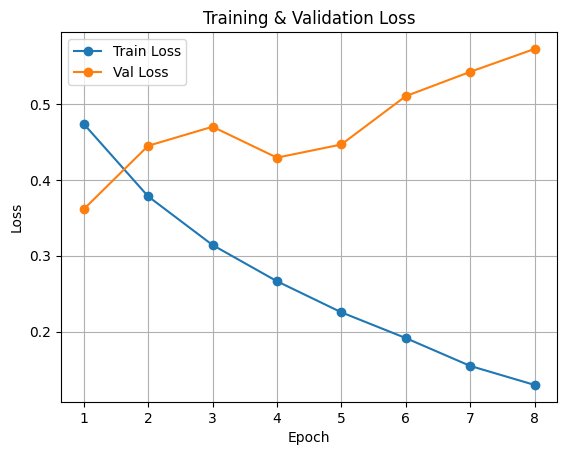

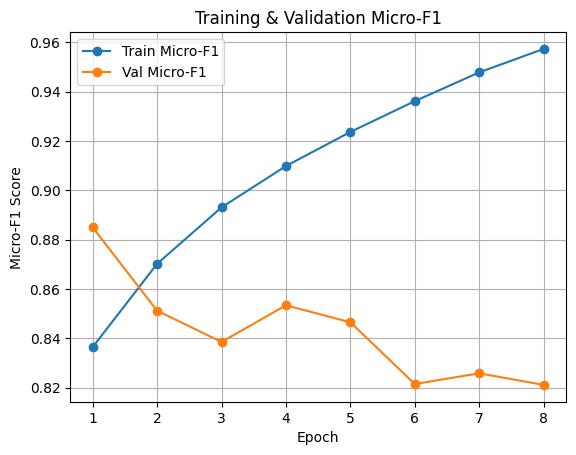

In [14]:
# Loss curve
plt.figure()
plt.plot(range(1, EPOCHS+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, EPOCHS+1), val_losses,   label="Val Loss",   marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# F1 curve
plt.figure()
plt.plot(range(1, EPOCHS+1), train_f1s, label="Train Micro-F1", marker='o')
plt.plot(range(1, EPOCHS+1), val_f1s,   label="Val Micro-F1",   marker='o')
plt.xlabel("Epoch")
plt.ylabel("Micro-F1 Score")
plt.title("Training & Validation Micro-F1")
plt.legend()
plt.grid(True)
plt.show()


In [15]:
# Load best model
model.load_state_dict(torch.load("best_bilstm_emocontext.pt"))

test_loss, test_micro_f1, y_test_true, y_test_pred = eval_model(model, test_loader, criterion)

print(f"Test loss: {test_loss:.4f}")
print(f"Test micro-F1: {test_micro_f1:.4f}")

print("\nClassification report (test):")
print(classification_report(
    y_test_true,
    y_test_pred,
    target_names=[id2label[i] for i in range(NUM_CLASSES)]
))


  0%|          | 0/87 [00:00<?, ?it/s]

Test loss: 0.3571
Test micro-F1: 0.8802

Classification report (test):
              precision    recall  f1-score   support

      others       0.95      0.92      0.93      4677
       happy       0.53      0.61      0.56       284
         sad       0.64      0.61      0.63       250
       angry       0.53      0.78      0.63       298

    accuracy                           0.88      5509
   macro avg       0.66      0.73      0.69      5509
weighted avg       0.89      0.88      0.89      5509



Confusion matrix:
 [[4292  130   72  183]
 [ 101  173    5    5]
 [  59   22  153   16]
 [  55    4    8  231]]


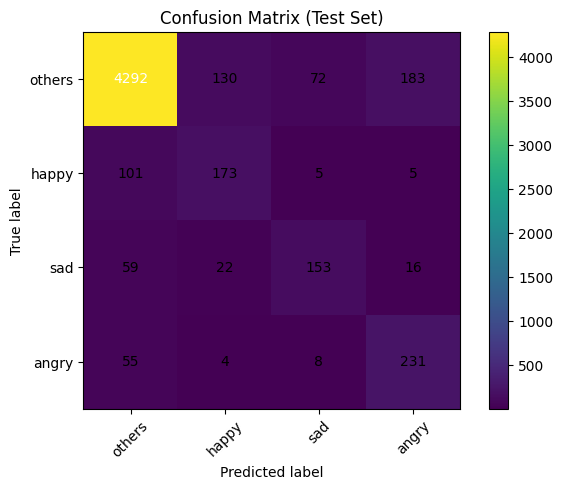

In [16]:
cm = confusion_matrix(y_test_true, y_test_pred)
classes = [id2label[i] for i in range(NUM_CLASSES)]

print("Confusion matrix:\n", cm)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Test Set)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], 'd'),
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


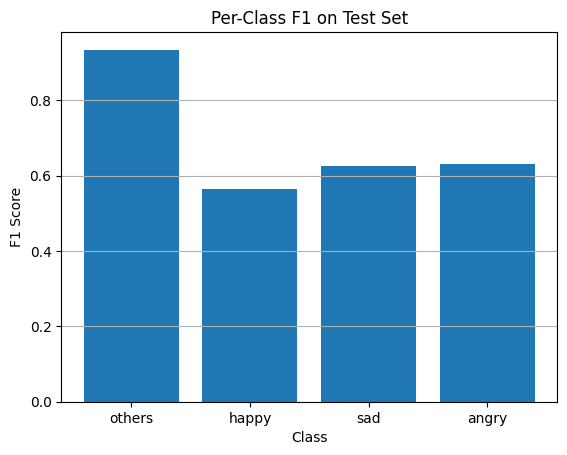

others: 0.9347
happy: 0.5644
sad: 0.6270
angry: 0.6303


In [17]:
# Per-class F1 using sklearn's report
report_dict = classification_report(
    y_test_true,
    y_test_pred,
    target_names=classes,
    output_dict=True
)

per_class_f1 = [report_dict[cls]["f1-score"] for cls in classes]

plt.figure()
plt.bar(classes, per_class_f1)
plt.xlabel("Class")
plt.ylabel("F1 Score")
plt.title("Per-Class F1 on Test Set")
plt.grid(axis='y')
plt.show()

for cls, f1_val in zip(classes, per_class_f1):
    print(f"{cls}: {f1_val:.4f}")
